In [28]:
from pyreadr import read_r
import pickle

from arboreto.algo import grnboost2
from arboreto.utils import load_tf_names
from pyscenic.utils import modules_from_adjacencies
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell, derive_auc_threshold

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase

import pandas as pd
import os
import seaborn as sns
import matplotlib as plt

import logging

### Prelimanary

Load count matrix and TFs names. \
\
Note: 
<ul>
    <li>count matrix generated by R script import_data.R, from file data/dpn.vnc.domain.labelled.rds </li>
    <li>TF names are copied from https://github.com/aertslab/pySCENIC/blob/master/resources/allTFs_dmel.txt (29.3.2023)</li>
<ul>

In [3]:
ex_matrix = pd.read_csv("../data/expression_mat.csv", index_col=0)  # load count matrix 
tf_names = load_tf_names("../data/allTFs_dmel.txt") # Derive list of Transcription Factors(TF) for Drosophila

In [95]:
ex_matrix.shape

(3855, 9751)

In [96]:
ex_matrix

,a,abd-A,Abd-B,Abl,abo,ac,acj6,Acph-1,Act5C,Act42A,...,lncRNA:CR43716,lncRNA:CR44997,asRNA:CR45151,lncRNA:CR45310,lncRNA:CR45425,asRNA:CR45822,asRNA:CR45891,lncRNA:CR45961,lncRNA:CR46032,lncRNA:CR46119
TP1_AACTCAGGTAAATACG,0.0,0.000000,0.0,0.0,0.466624,0.000000,0.0,0.0,2.764117,1.750383,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP1_TCACGAATCTATCGCC,0.0,1.053208,0.0,0.0,0.000000,0.483831,0.0,0.0,2.879282,1.053208,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP1_TACGGTACAATAGAGT,0.0,0.813928,0.0,0.0,0.000000,0.000000,0.0,0.0,2.458085,1.059571,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP1_CAACTAGAGAGACGAA,0.0,0.000000,0.0,0.0,0.000000,0.888313,0.0,0.0,2.728522,2.006819,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP1_GCGCCAAAGTCGATAA,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,3.294131,1.989672,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TP2.2_AACACGTCATTCACTT,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,2.463590,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP2.2_TCTTTCCGTACCGTTA,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,3.506908,2.466545,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP2.2_GATTCAGCACACGCTG,0.0,2.470005,0.0,0.0,0.000000,1.858055,0.0,0.0,3.119940,1.858055,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
TP2.2_TGAGCATGTGATGTCT,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.854410,2.466052,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0


Load ranking databases (for motif enrichment)  --> https://resources.aertslab.org/cistarget/ (https://resources.aertslab.org/cistarget/databases/drosophila_melanogaster/dm6/flybase_r6.02/mc8nr/gene_based/)

In [4]:
db_fnames = "../data/dm6-5kb-upstream-full-tx-11species.mc8nr.genes_vs_motifs.rankings.feather"
dbs = [RankingDatabase(fname=db_fnames, name=os.path.splitext(os.path.basename(db_fnames))[0])]
dbs


[FeatherRankingDatabase(name="dm6-5kb-upstream-full-tx-11species.mc8nr.genes_vs_motifs.rankings")]

Motif annotation file: https://resources.aertslab.org/cistarget/motif2tf/ (v8 matches mc8nr db)

In [5]:
motif_annotation_file = "../data/motifs-v8-nr.flybase-m0.001-o0.0.tbl"

#### Run Pipeline
line by line to get familiar with the outputs, and time the commands. 

In [6]:
# sample matrix:
ex_matrix_sub = ex_matrix.iloc[1:100,1:500]
# run first step
adjacencies = grnboost2(ex_matrix_sub, tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph
4 partitions
computing dask graph
shutting down client and local cluster
finished


In [13]:
adjacencies

,TF,target,importance
53,Brd,E(spl)m5-HLH,3.687917e+01
495,sna,sca,2.138833e+01
465,sala,sca,1.828094e+01
333,E(spl)m5-HLH,rst,1.794850e+01
172,FER,Gart,1.668760e+01
...,...,...,...
218,hay,Arl1,3.657316e-16
248,ImpL2,nkd,2.747921e-16
22,AnxB9,ase,2.530264e-16
132,ec,LanA,1.584127e-16


In [7]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix_sub)) 
modules


2023-05-10 13:54:07,717 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-05-10 13:54:07,726 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2023-05-10 13:54:07,910 - pyscenic.utils - INFO - Creating modules.


[Regulon(name='Regulon for Act42A', gene2weight=frozendict.frozendict({'E(spl)malpha-BFM': 7.428199713790732, 'Fib': 7.323256610900561, 'dsh': 1.5115018773827644, 'H': 1.5071250144330333, 'Myb': 1.3874794131120578, 'ImpL2': 1.3783706619761589, 'E(spl)mbeta-HLH': 1.3284373969106547, 'PpV': 1.1833222206380187, 'smo': 1.0721313181227967, 'Ras64B': 1.0183952853965959, 'Grip91': 0.9726385071576127, 'Bsg25D': 0.939653580136407, 'E(spl)m4-BFM': 0.9279786243028023, 'if': 0.9086242838106927, 'ft': 0.8802354954139444, 'kni': 0.7713219956694409, 'aop': 0.7453764538966444, 'Rm62': 0.734791631485496, 'mei-W68': 0.6960486411536495, 'l(2)37Bb': 0.6948864992458337, 'okr': 0.5412205097021304, 'RpII215': 0.532426788194417, 'Axs': 0.5166829878761777, 'slo': 0.4856662818033316, 'ben': 0.4856202025972388, 'Khc': 0.47813899604449644, 'CycA': 0.4419424980458826, 'crp': 0.4396582921942129, 'dx': 0.43153762900778647, 'ase': 0.4194227288175102, 'fz': 0.40881457600527477, 'Act42A': 1.0}), gene2occurrence=frozend

In [21]:
modules[1]


Regulon(name='Regulon for Act5C', gene2weight=frozendict.frozendict({'chif': 1.862244838145099, 'Sap-r': 1.7134937978265417, 'inv': 1.648536505862241, 'Mybbp1A': 1.6254871975386755, 'CycA': 1.621240140658466, 'hth': 1.495037858642255, 'Poxm': 1.4406668015333692, 'kkv': 1.385262928056424, 'Hsp67Ba': 1.2257543091651377, 'numb': 1.1888846149543304, 'ifc': 1.1723181001823542, 'RpII215': 1.1571919566646451, 'exd': 0.9099037081364286, 'Lar': 0.8962733511521475, 'sens': 0.7597792426852297, 'okr': 0.6839832913971687, 'l(1)10Bb': 0.6826278894700637, 'Gart': 0.6787329433409397, 'Gli': 0.6493283879687307, 'Hsp27': 0.6424547826875752, 'PpV': 0.5823025276632724, 'cort': 0.5621610033854862, 'bic': 0.5572906209563305, 'shi': 0.5473106732062405, 'Ras64B': 0.5342821512515061, 'hfw': 0.5315908599017927, 'sesB': 0.5233149967354643, 'peb': 0.5034281489411072, 'mago': 0.4732398930554864, 'bsh': 0.4707982703934201, 'E(bx)': 0.44031481432773234, 'ninaA': 0.41890955227139764, 'E(z)': 0.4051692219289528, 'wek'

In [8]:
df = prune2df(dbs, modules, motif_annotations_fname=motif_annotation_file) # Prune modules for targets with cis regulatory footprints (RcisTarget)
df

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Enrichment  ...          
                                                                  AUC  ... RankAtMax
TF      MotifID                                                        ...          
RpII215 stark__STATAWAWRSVVV                                 0.128724  ...       318
        swissregulon__hs__TBP.p2                             0.192343  ...       772
        jaspar__MA0108.2                                     0.131555  ...       313
        cisbp__M4010                                         0.126311  ...         3
        factorbook__TBP                                      0.154107  ...       379
aop     cisbp__M4602                                         0.248502  ...       373
        flyfactorsurvey__Eip74EF_SANGER_5_FBgn0000567        0.240139  ...       350
        cisbp__M4936                                         0.249178  ...       273
        cisbp__M4554                                         0.246568  ...       355
        swissregulon__hs__EHF.p2                             0.244200  ...       399
        cisbp__M4549                                         0.277842  ...       130
        cisbp__M5157                                         0.256381  ...       302
        transfac_pro__M07702                                 0.248067  ...       286
        taipale_tf_pairs__RFX3_ETV7_NNNMGGAANNNNNTCCNNN...   0.266241  ...       639
D       taipale__SOX8_DBD_AACAATRTKCAGWGTT                   0.089668  ...       230
RpII215 swissregulon__hs__TBP.p2                             0.131163  ...       853
abd-A   cisbp__M0913                                         0.143972  ...       341
        cisbp__M1044                                         0.159827  ...       433
        cisbp__M1158                                         0.170461  ...       375
        cisbp__M0977                                         0.165748  ...       899
opa     flyfactorsurvey__Ci_SANGER_5_FBgn0004859             0.170911  ...       528
        cisbp__M6266                                         0.171127  ...       650
        cisbp__M4149                                         0.167566  ...       801
        flyfactorsurvey__opa_SOLEXA_FBgn0003002              0.202234  ...       132
        flyfactorsurvey__Opa_SANGER_5_FBgn0003002            0.175768  ...       510
run     tfdimers__MD00482                                    0.174594  ...       222
Jra     yetfasco__YBL103C_1445                               0.194122  ...       107
RpII215 stark__STATAWAWRSVVV                                 0.097176  ...       155
        swissregulon__hs__TBP.p2                             0.114704  ...       280
        jaspar__MA0108.2                                     0.094076  ...       635
        cisbp__M4010                                         0.093877  ...       352
abd-A   cisbp__M1044                                         0.142068  ...       341
        cisbp__M1158                                         0.151521  ...       451
        cisbp__M0977                                         0.147332  ...       375
aop     cisbp__M4549                                         0.147332  ...       671
l(1)sc  transfac_pro__M02841                                 0.151080  ...       478
        hocomoco__ASCL2_HUMAN.H10MO.D                        0.142852  ...       291
opa     flyfactorsurvey__Ci_SANGER_5_FBgn0004859             0.170621  ...       189
        transfac_pro__M07290                                 0.171027  ...       650
        cisbp__M4149                                         0.174014  ...       801
        transfac_public__M00450                              0.170882  ...       279
        flyfactorsurvey__opa_SOLEXA_FBgn0003002              0.202175  ...       132
pnt     cisbp__M0706                                         0.180974  ...       829
        cisbp__M0708                                         0.175848  ...       224
        cisbp__M0701                                         0.1

In [9]:
regulons = df2regulons(df) # convert data frame to rergulons
regulons

Create regulons from a dataframe of enriched features.
Additional columns saved: []


[Regulon(name='D(+)', gene2weight=frozendict.frozendict({'cact': 0.3893133800594745, 'E(spl)m4-BFM': 1.4452138639065304, 'D': 1.0, 'h': 0.6278017964648258, 'Dll': 0.5740194868213099, 'pbl': 0.7165703231355008}), gene2occurrence=frozendict.frozendict({}), transcription_factor='D', context=frozenset({'activating', 'taipale__SOX8_DBD_AACAATRTKCAGWGTT.png'}), score=0.715617376342109, nes=0.0, orthologous_identity=0.0, similarity_qvalue=0.0, annotation=''),
 Regulon(name='Jra(+)', gene2weight=frozendict.frozendict({'Sh': 0.05394001803681826, 'E(spl)m8-HLH': 0.09971463746665668, 'robo2': 0.3529618498644702, 'gro': 0.46223911796009337}), gene2occurrence=frozendict.frozendict({}), transcription_factor='Jra', context=frozenset({'activating', 'yetfasco__YBL103C_1445.png'}), score=1.3098561847379806, nes=0.0, orthologous_identity=0.0, similarity_qvalue=0.0, annotation=''),
 Regulon(name='RpII215(+)', gene2weight=frozendict.frozendict({'Pka-C1': 0.5202893340512947, 'E(spl)mgamma-HLH': 0.4982536751

In [10]:
auc_mtx = aucell(ex_matrix_sub, regulons, num_workers=1)
auc_mtx

100%|██████████| 9/9 [00:01<00:00,  4.96it/s]


Regulon,D(+),Jra(+),RpII215(+),abd-A(+),aop(+),l(1)sc(+),opa(+),pnt(+),run(+)
Cell,,,,,,,,,
TP1_AAACCTGAGTAACCCT,0.0,0.0,0.00000,0.0,0.0,0.012345,0.004238,0.0,0.0
TP1_AAAGATGTCTCCCTGA,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0
TP1_AAAGCAATCTTCCTTC,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0
TP1_AAATGCCGTGGGTCAA,0.0,0.0,0.00000,0.0,0.0,0.000367,0.000336,0.0,0.0
TP1_AACTGGTGTCAACATC,0.0,0.0,0.00000,0.0,0.0,0.033732,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
TP1_TTCGAAGGTTAAGGGC,0.0,0.0,0.00365,0.0,0.0,0.000000,0.000000,0.0,0.0
TP1_TTCGGTCAGTTGAGTA,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0
TP1_TTCTACAAGTACTTGC,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0


Visualization of aucell table

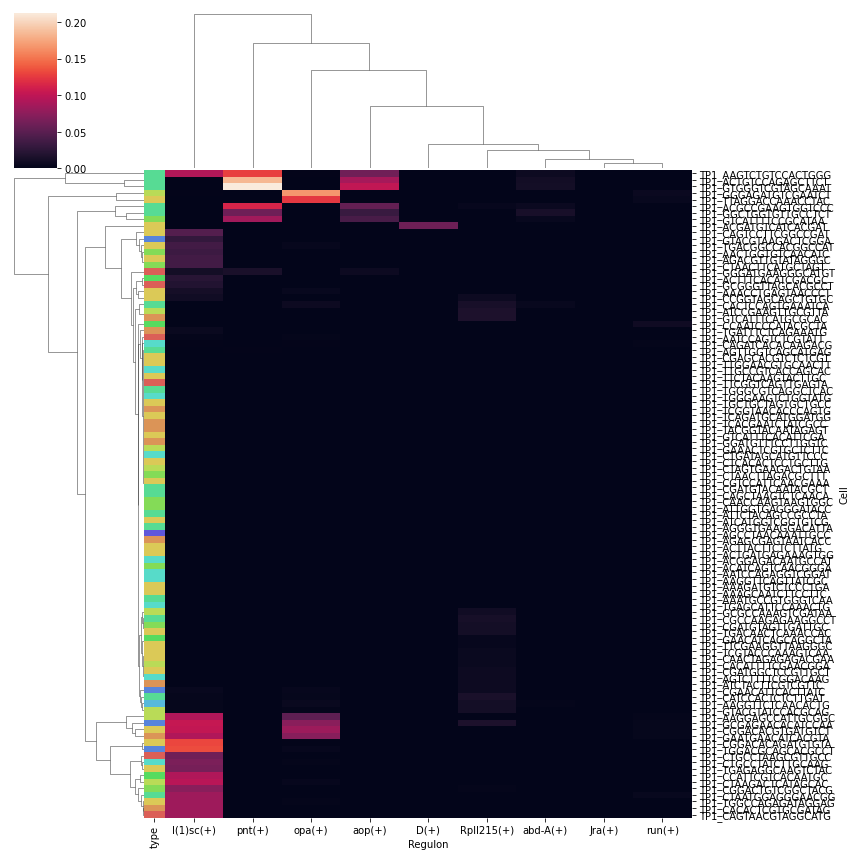

In [80]:

types_df = pd.read_csv("../data/cell_type.csv", index_col=0) 

sns.color_palette("hls", 15)
lut = dict(zip(types_df.type.unique(), sns.color_palette("hls", 15)))
cell_colors = types_df.type.map(lut)
row_colors = auc_mtx.merge(cell_colors, how='left', left_index=True, right_index=True).type
ax= sns.clustermap(auc_mtx, figsize=(12,12,),yticklabels=True, xticklabels=True, row_colors=row_colors)



In [11]:
from pyscenic.aucell import create_rankings

create_rankings(ex_matrix)  # ranking of gene expression in each cell 



,Rpn8,CG15744,CG8155,Aatf,Ero1L,CG11404,NaCP60E,Cdk1,ATPsyndelta,Lsd-1,sca,lncRNA:CR43870,shi,CG14573,lncRNA:CR45473,Nap1,CG10984,Rbfox1,lncRNA:CR44953,CG9886,Nadsyn,Ubx,mars,nrv2,snoRNA:Or-CD4,CG3655,CG1218,pcm,CG16926,pgc,sano,CG7638,Gr8a,MED21,CG1663,Ptp69D,Hip14,MME1,CG2147,dbr,...,GstD10,RpS29,IKKepsilon,Fbxl7,CarT,CG14100,CG7639,dpr17,comt,CG12674,Kaz1-ORFB,Hipk,DNAlig4,Grip91,CG14204,Mst36Fa,bib,LpR1,stai,lncRNA:CR43356,lwr,mrn,asRNA:CR45999,CG11470,CG15282,DNApol-alpha73,asRNA:CR45281,Tsen2,CG9804,cutlet,Ance-3,Bacc,CG15098,CG3770,NO66,SCCRO3,Pgant4,Npc2h,Hen1,CG12391
TP1_AACTCAGGTAAATACG,1271,2641,2642,2643,1272,2644,2645,216,181,2646,142,2647,2648,2649,2650,406,2651,2652,2653,2654,2655,1273,2656,1274,2657,1275,2658,2659,2660,2661,2662,2663,2664,754,2665,2666,1276,2667,2668,2669,...,9718,74,9719,9720,9721,9722,9723,9724,9725,9726,9727,2639,9728,9729,9730,9731,1269,9732,9733,9734,136,1270,9735,9736,9737,2640,9738,9739,9740,9741,9742,54,9743,9744,9745,9746,9747,9748,9749,9750
TP1_TCACGAATCTATCGCC,2568,2569,2570,2571,2572,2573,2574,332,400,2575,401,2576,2577,2578,2579,1280,2580,750,2581,2582,2583,1281,751,1282,2584,2585,2586,2587,2588,2589,2590,1283,2591,1284,2592,2593,2594,2595,2596,2597,...,9717,69,9718,9719,9720,9721,9722,9723,9724,9725,9726,1278,9727,9728,9729,9730,9731,9732,9733,9734,149,2567,9735,9736,9737,9738,9739,9740,9741,9742,9743,65,9744,9745,1279,9746,9747,9748,9749,9750
TP1_TACGGTACAATAGAGT,559,2507,2508,2509,2510,2511,2512,278,279,2513,335,2514,2515,2516,2517,788,2518,1282,2519,2520,2521,1283,789,1284,2522,1285,2523,2524,2525,2526,2527,1286,2528,790,2529,1287,1288,791,2530,2531,...,9719,54,2504,9720,9721,9722,9723,9724,2505,9725,9726,2506,9727,9728,9729,9730,9731,9732,9733,9734,100,9735,9736,9737,9738,9739,9740,9741,1280,9742,9743,59,9744,9745,1281,9746,9747,9748,9749,9750
TP1_CAACTAGAGAGACGAA,2421,2422,2423,2424,2425,2426,2427,345,176,2428,1202,2429,2430,2431,2432,706,2433,1203,2434,2435,2436,1204,2437,2438,2439,2440,2441,2442,2443,2444,2445,707,2446,708,2447,1205,2448,2449,2450,2451,...,9718,50,9719,9720,9721,9722,9723,9724,9725,9726,9727,2417,9728,2418,9729,9730,2419,9731,9732,9733,243,9734,9735,9736,9737,9738,9739,9740,2420,9741,9742,41,9743,9744,9745,9746,9747,9748,9749,9750
TP1_GCGCCAAAGTCGATAA,2359,2360,1113,2361,2362,2363,2364,356,357,2365,1114,2366,671,2367,2368,1115,2369,2370,2371,2372,2373,2374,2375,1116,2376,1117,2377,2378,2379,2380,2381,2382,2383,1118,2384,2385,2386,2387,2388,2389,...,9718,28,9719,9720,9721,9722,9723,9724,9725,9726,9727,1112,9728,9729,9730,9731,355,9732,9733,9734,157,9735,9736,9737,9738,2357,9739,9740,9741,9742,9743,64,9744,9745,9746,2358,9747,9748,9749,9750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TP2.2_AACACGTCATTCACTT,776,777,778,779,780,781,782,271,272,783,273,784,785,786,787,274,788,275,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,276,804,805,806,807,808,809,...,9715,28,9716,9717,9718,9719,9720,9721,775,9722,9723,9724,9725,9726,9727,9728,9729,9730,9731,9732,270,9733,9734,9735,9736,9737,9738,9739,9740,9741,9742,1,9743,9744,9745,9746,9747,9748,9749,9750
TP2.2_TCTTTCCGTACCGTTA,783,784,785,786,787,788,789,790,791,792,265,793,794,795,796,266,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,...,9718,20,9719,9720,9721,779,9722,9723,9724,9725,9726,9727,9728,9729,9730,9731,780,9732,9733,9734,139,9735,9736,9737,9738,9739,9740,9741,9742,9743,9744,2,9745,9746,781,9747,9748,9749,9750,782
TP2.2_GATTCAGCACACGCTG,712,713,714,715,716,717,718,223,224,719,720,721,722,723,724,225,226,725,726,727,728,227,228,229,729,730,230,731,732,733,734,735,736,737,738,739,740,741,742,743,...,9715,56,710,9716,9717,9718,9719,9720,9721,9722,9723,9724,9725,9726,9727,

get cells annotation

In [143]:
cell_type = pd.read_csv("../data/cell_type.csv", index_col=0)
withtype = pd.merge(auc_mtx[0:10], cell_type, left_index=True, right_index=True)

withtype  # last column is type, add later to heatmap # TODO 

,E(spl)m7-HLH(+),Hrb98DE(+),Hsf(+),Jra(+),Myb(+),RpII215(+),aop(+),ase(+),cg(+),en(+),esg(+),fkh(+),hth(+),kn(+),mor(+),opa(+),pnt(+),slou(+),wor(+),type
TP1_AAACCTGAGTAACCCT,0.008319,0.004071,0.000363,0.0,0.0,0.013272,0.000000,0.015149,0.0,0.000957,0.000000,0.0,0.059390,0.0,0.025444,0.0,0.000000,0.0,0.014446,7-4
TP1_AAAGATGTCTCCCTGA,0.024957,0.011955,0.000000,0.0,0.0,0.003209,0.000000,0.045447,0.0,0.000000,0.000000,0.0,0.002373,0.0,0.005865,0.0,0.000000,0.0,0.000000,7-4
TP1_AAAGCAATCTTCCTTC,0.015252,0.004269,0.000000,0.0,0.0,0.011552,0.000000,0.027773,0.0,0.000000,0.000000,0.0,0.010837,0.0,0.024949,0.0,0.000000,0.0,0.000000,7-4
TP1_AAATGCCGTGGGTCAA,0.027730,0.007685,0.000000,0.0,0.0,0.008343,0.000000,0.050497,0.0,0.000000,0.000000,0.0,0.007508,0.0,0.017801,0.0,0.000000,0.0,0.007223,MG
TP1_AACTGGTGTCAACATC,0.027730,0.000000,0.000000,0.0,0.0,0.009626,0.000000,0.050497,0.0,0.000000,0.000000,0.0,0.019641,0.0,0.011717,0.0,0.003806,0.0,0.000000,1-2
TP1_AAGGAGCCATTGCGGC,0.027730,0.000854,0.000000,0.0,0.0,0.008605,0.000000,0.050497,0.0,0.000000,0.000862,0.0,0.026082,0.0,0.019251,0.0,0.000843,0.0,0.009198,1-1
TP1_AAGGTTCAGTTATCGC,0.004160,0.005977,0.000000,0.0,0.0,0.011469,0.000000,0.007575,0.0,0.000000,0.000000,0.0,0.015722,0.0,0.024546,0.0,0.000000,0.0,0.000000,5-3
TP1_AAGGTTCTCAACACTG,0.026344,0.005349,0.000000,0.0,0.0,0.005776,0.004314,0.047972,0.0,0.000000,0.000000,0.0,0.015605,0.0,0.009234,0.0,0.000000,0.0,0.028891,3-5
TP1_AAGTCTGTCCACTGGG,0.075261,0.007091,0.001090,0.0,0.0,0.010910,0.000000,0.035348,0.0,0.002870,0.000862,0.0,0.056566,0.0,0.024342,0.0,0.051217,0.0,0.025280,MG
TP1_AATCCAGAGGTCGGAT,0.000000,0.004914,0.000000,0.0,0.0,0.011070,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.019501,0.0,0.027017,0.0,0.000000,0.0,0.000000,5-3


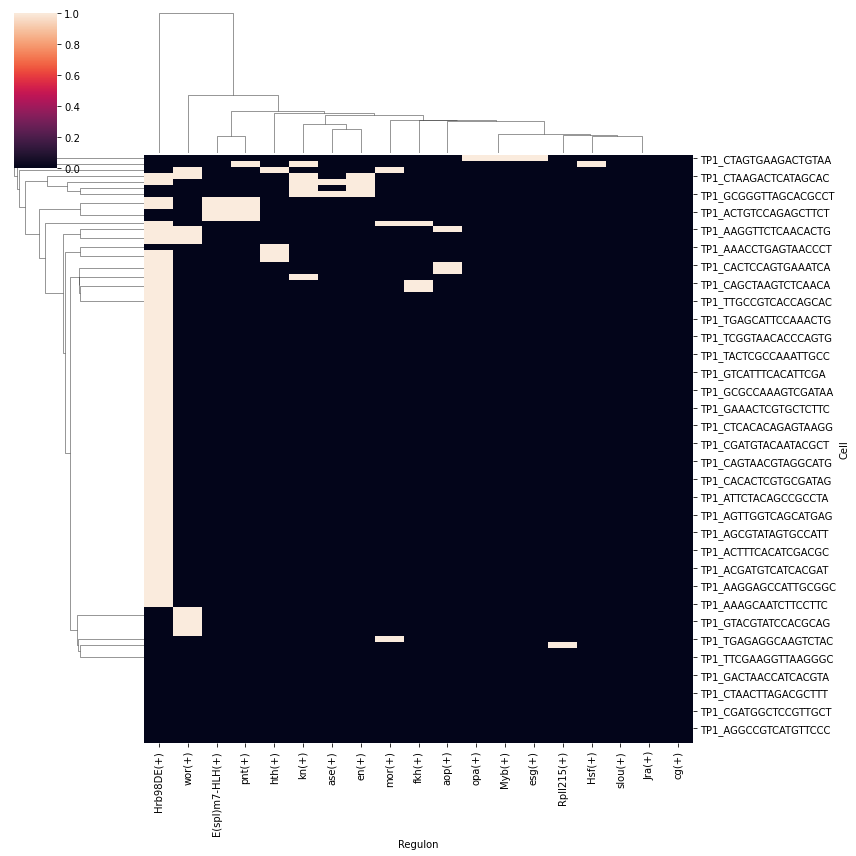

In [50]:
from pyscenic.binarization import binarize

binary_aucell = binarize(auc_mtx)
sns.clustermap(binary_aucell[0], figsize=(12,12))
# binary_aucell[1]  # thresholds per regulon

# can visualize each regulon's distribution + this threshold 

Binarization

Threshold is automatically found. \
if distribution is unimodal => threshold is mean+2sd \
else => fit two component Gaussian Mixture model on the AUC distribution using an Expectation-Maximization algorithm to identify the peaks in the distribution \
(https://github.com/aertslab/pySCENIC/blob/master/src/pyscenic/binarization.py)


Draw distributions of AUC values for a regulon across cells. Functions taken from https://pyscenic.readthedocs.io/en/stable/faq.html

In [92]:
import matplotlib.pyplot as plt

def plot_binarization(auc_mtx: pd.DataFrame, regulon_name: str, threshold: float, ax=None) -> None:
    """
    Plot the "binarization" process for the given regulon.

    :param auc_mtx: The dataframe with the AUC values for all cells and regulons (n_cells x n_regulons).
    :param regulon_name: The name of the regulon.
    :param bins: The number of bins to use in the AUC histogram.
    :param threshold: The threshold to use for binarization.
    """
    if ax is None:
        ax=plt.gca()
   
    auc_mtx[regulon_name].hist(ax=ax, bins='auto')  # originally bins are chosen to be 200

    ylim = ax.get_ylim()
    ax.plot([threshold]*2, ylim, 'r:')
    ax.set_ylim(ylim)
    ax.set_xlabel('AUC')
    ax.set_ylabel('# cells')
    ax.set_title(regulon_name)

    


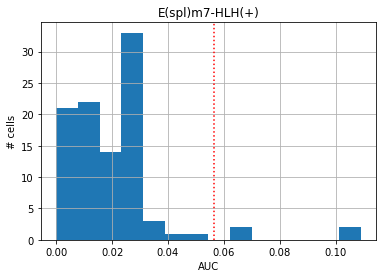

In [93]:
if not os.path.exists("results/figs"):
    os.mkdir("results/figs")

for regulon in list(auc_mtx.columns.values):
    plot_binarization(auc_mtx=auc_mtx, regulon_name=regulon, threshold=binary_aucell[1][regulon])
    plt.savefig(f"results/figs/{regulon}.pdf")
    # break

In [28]:
if not os.path.exists("results/"):
    os.mkdir("results")

In [35]:
# TODO: save intermediate products to file - see tutorial https://github.com/aertslab/pySCENIC/blob/master/notebooks/pySCENIC%20-%20Full%20pipeline.ipynb
n = 1  # TODO: decide on n based on computational resources 
all_results = [None] * n
for i in range(0, n):  # TODO: replace N, replace ex_matrix_sub with ex_matrix
    run_num = i+1
    if not os.path.exists(f"results/run_{run_num}"): os.mkdir(f"results/run_{i}")

    """ phase 1 - GRN inference, generation of co-expression modules """
    adjacencies = grnboost2(ex_matrix_sub, tf_names, verbose=True) # adjacencies table of tf, target and importance weight
    modules = list(modules_from_adjacencies(adjacencies, ex_matrix_sub)) # module generation - candidate regulons from TF-target gene interactions 
    # save to files:
    adjacencies.to_csv(f"results/run_{run_num}/adjacencies.csv", index=False, sep='\t')
    with open(f"results/run_{run_num}/modules.pkl", 'wb') as f:
        pickle.dump(modules, f)

    """ phase 2+3 - Regulon prediction """
    df = prune2df(dbs, modules, motif_annotations_fname=motif_annotation_file) # Prune modules for targets with cis regulatory footprints (RcisTarget)
    regulons = df2regulons(df) # convert data frame to rergulons
    # save to files:
    df.to_csv(f"results/run_{run_num}/motifs.csv")
    with open(f"results/run_{run_num}/regulons.pkl", 'wb') as f:
        pickle.dump(regulons, f)

    """ phase 4 - cellular enrichment """
    auc_mtx = aucell(ex_matrix_sub, regulons, num_workers=1)  # Calculate enrichment of gene signatures for single cells. # TODO: change num_workers
    auc_mtx.to_csv(f"results/run_{run_num}/AUCell_mat.csv")
    # auc_mtx.to_pickle(f"results/results_{i+1}.pkl")# pickle results to results/ folder for later analysis
    # AUCell returns A dataframe with the AUCs (n_cells x n_modules).

    types_df = pd.read_csv("../data/cell_type.csv", index_col=0) 

    # heatmap
    lut = dict(zip(types_df.type.unique(), sns.color_palette("hls", len(types_df.type.unique()))))
    cell_colors = types_df.type.map(lut)
    row_colors = auc_mtx.merge(cell_colors, how='left', left_index=True, right_index=True).type
    ax= sns.clustermap(auc_mtx, figsize=(12,12,),yticklabels=True, xticklabels=True, row_colors=row_colors)
    plt.savefig(f"results/run_{run_num}/AUCell_heatmap.png")

# TODO: transfer to a script, that also redirects output to log files 


    

preparing dask client
parsing input
creating dask graph
4 partitions
computing dask graph
shutting down client and local cluster



2023-04-20 12:27:53,868 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-04-20 12:27:53,874 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2023-04-20 12:27:54,037 - pyscenic.utils - INFO - Creating modules.


finished


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Create regulons from a dataframe of enriched features.
Additional columns saved: []


100%|██████████| 19/19 [00:00<00:00, 898.68it/s]


In [12]:
    
directory = "results/"
count_per_cell = {}
for filename in os.listdir(directory):  # iterate over all pickle files
     file = os.path.join(directory, filename)
     if not file.endswith(".pkl"):
         continue
     res_df = pd.read_pickle(file)
     #res_df.to_csv(f'{os.path.splitext(file)[0]}.csv')
     
     

RSS 

In [27]:

from pyscenic.rss import regulon_specificity_scores

types_df = pd.read_csv("../data/cell_type.csv", index_col=0) 
types_serise = types_df[types_df.index.isin(auc_mtx.index)].squeeze()
regulon_specificity_scores(auc_mtx, types_serise)



,D(+),Jra(+),RpII215(+),abd-A(+),aop(+),l(1)sc(+),opa(+),pnt(+),run(+)
7-1,0.167445,NaN,0.258809,0.167445,0.167445,0.267428,0.224376,0.167445,0.252779
7-4,0.167445,NaN,0.210984,0.233313,0.228250,0.305997,0.240791,0.229331,0.215668
1-1,0.167445,NaN,0.262907,0.293419,0.234718,0.212991,0.193588,0.234916,0.167445
5-6,0.167445,NaN,0.253189,0.167445,0.167445,0.191525,0.180677,0.167445,0.167445
1-2,0.167445,NaN,0.242586,0.167445,0.167445,0.289893,0.215827,0.167445,0.199178
5-2,0.167445,NaN,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445,0.275542
MG,0.242176,NaN,0.282668,0.278727,0.296368,0.195516,0.182092,0.296742,0.193111
5-3,0.167445,NaN,0.187005,0.167445,0.167445,0.184675,0.234872,0.167445,0.222841
3-5,0.167445,NaN,0.240773,0.167445,0.167445,0.167445,0.167445,0.167445,0.167445
3-2,0.167445,NaN,0.178970,0.167445,0.167445,0.351520,0.249559,0.167445,0.221819
